
# Project: Analyzing no-show medical appointments

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

For this project we'll be taking a look at what factors might contribute to people missing their medical appointments. The dataset we'll be using contains information on 100k+ medical appointments scheduled in Brazil.

Our main interest is what factors can be used to predict whether a person will show up to their medical appointment or not. To help guide the analysis, we'll answer the following questions:

1. Does the likelihood of missing appointments depend on gender?
2. What is the effect of the waiting time on missing/showing up?
3. Does age affect no show appointments?
4. Can we build a simple model to predict whether a person will show up or not?

To start off, let's import the packages and data we need for this project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# To plot the visulizations inline with the notebook
% matplotlib inline

# Import the data
df = pd.read_csv('noshow.csv')

<a id='wrangling'></a>
## Data Wrangling

Let's continue by getting an idea of the general properties of the dataset.

In [2]:
# print the first 5 rows of the dataset
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
# number of rows and columns
df.shape

(110527, 14)

As we can see, the dataset contains 14 columns and 110,527 appointments. The **SheduledDay** and **AppointmentDay** columns refer to the date the appointment was scheduled and the date of the actual appointment itself respectively. The **Scholarship** column indicates whether the patient received welfare through Brazil's so-called *Bolsa Familia* program. The **No-show** column is a little bit tricky: *No* means that the person did show up to the appointment and *Yes* means that this appointment was missed. 

Now let's take a look at the data types, missing values, and duplicates:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [5]:
# check for duplicates
df.duplicated().sum()

0

None of the columns appears to have any missing values, and there are no duplicates. One issue with the data that we can see from here is that the dates are formatted as objects. 

Some summary statistics:

In [6]:
# Summary statistics
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


For **Age**, the lowest value is -1 and the highest value is 115, both of which seem incorrect. Furthermore, the max for handicap is 4, where we would expect it to be one because it's a binary variable. Let's investigate this further:

In [7]:
# different values for handicap and their counts
df.Handcap.value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64

### Data Cleaning

In this section we'll address the issues with the data.

First we can drop the **PatientID** and **AppointmentID** columns, because they won't be helpful in predicting if a patient will show up for the appointment.

In [8]:
# drop columns
df.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)

Let's fix some typos and the formatting of the column labels, as well as change the data type of the columns with dates:

In [9]:
# change all column labels to lower case
df.columns = [x.lower() for x in df.columns]
# rename columns
df = df.rename(columns = {'scheduledday':'scheduled_day','appointmentday':'appointment_day',
                          'neighbourhood':'neighborhood','hipertension':'hypertension', 'handcap':'handicap',
                          'no-show':'no_show'})
# change ScheduledDay and AppointmentDay data types to datetime
df.iloc[:, 1:3] = df.iloc[:, 1:3].apply(pd.to_datetime, errors='coerce')
# drop the timestamp from scheduledday
df['scheduled_day'] = df['scheduled_day'].dt.normalize()

As we found out earlier, the **age** and **handicap** columns had some anomalies. For age, I'll assume that any value below 0 or greater than 105 is an error. In the case of handicap, any value other than 0 will be assumed to mean that the patient has a handicap (and thus will be set to 1).

In [10]:
# drop rows with age <0 or >105
df.drop(df[df.age < 0].index, inplace=True)
df.drop(df[df.age > 105].index, inplace=True)
# set handicap to either 0 or 1
df.loc[df.handicap != 0, 'handicap'] = 1

Because we need the wait time (difference between **appointment_day** and **scheduled_day**) to answer one of our research questions, we have to calculate a new column with this information.

In [11]:
# add a new column for the wait time
df['wait_time'] = df['appointment_day'] - df['scheduled_day']
# drop any negative wait times
df.drop(df[df.wait_time.dt.days < 0].index, inplace=True)
# Change the wait_time variable from timedelta to int
df['wait_time'] = df['wait_time'].dt.days
# see how many rows are left
df.shape

(110516, 13)

After cleaning the data, we have a total of 110,516 appointmens left. Finally, I'll change the values in the **no_show** column from "No" and "Yes" to 0 and 1 respectively. Transforming them into integers will make it easier to manipulate this data later on.

In [12]:
df.loc[df.no_show == 'No', 'no_show'] = 0
df.loc[df.no_show == 'Yes', 'no_show'] = 1

<a id='eda'></a>
## Exploratory Data Analysis

In this section we'll further explore the data, starting by analyzing the variables one at a time. After that we can move on to the research questions and investigate the relationships between variables.


#### Gender

How many appointments were made by men and how many were made by women?

In [13]:
# value counts per gender
df['gender'].value_counts()

F    71831
M    38685
Name: gender, dtype: int64

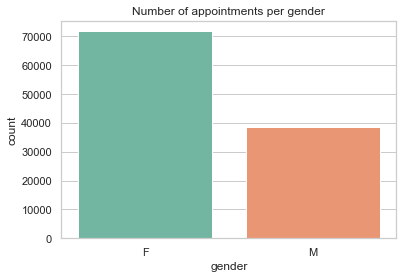

In [14]:
# visualization in a bar chart
sns.set(style='whitegrid')
ax = sns.countplot(x=df.gender, data=df, palette='Set2')
ax.set_title('Number of appointments per gender');


Out of a total of 110,516 appointments, 71,831 were made by women and 38,685 were made by men.

#### Age

Let's look at the number of appointments per age.

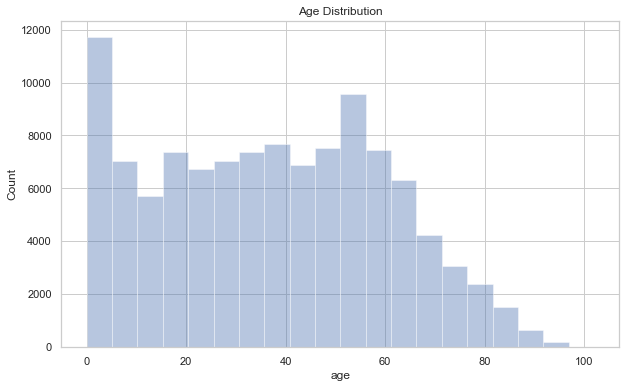

In [15]:
#Histogram of age
plt.figure(figsize=(10,6))
ax = sns.distplot(df.age, bins=20, kde=False)
ax.set_title('Age Distribution')
ax.set(ylabel='Count');

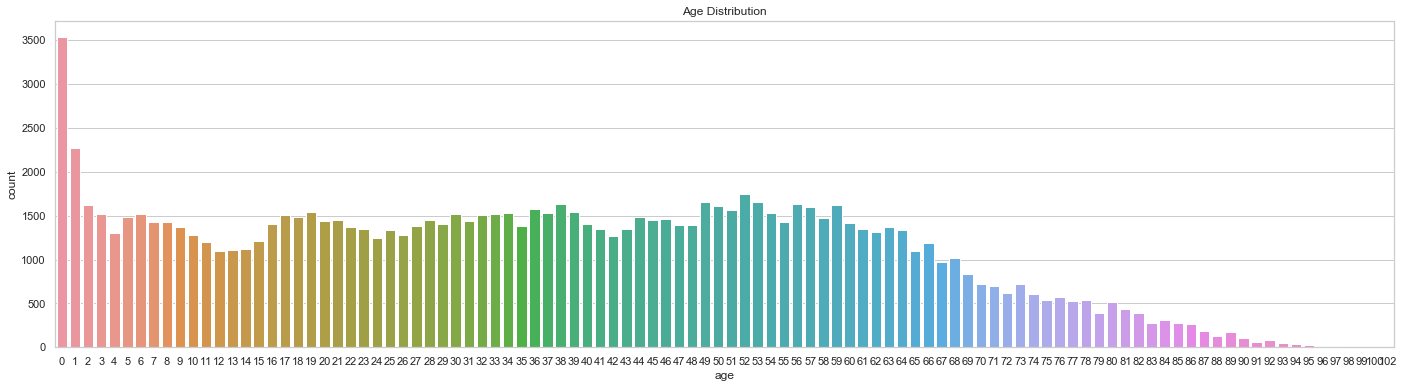

In [16]:
#More granular visualization of number of appointments per age
plt.figure(figsize=(24,6))
ax = sns.countplot(x=df.age, data=df,)
ax.set_title('Age Distribution');

There are more appointments for 0 and 1 year olds than for any other age. After that the number of appointments stays fairly constant, until it gradually declines as age increases past 60.

#### Wait time



The last variable we'll be examining is the wait time, which is the difference between the date the appointment was made and the date the appointment took place.

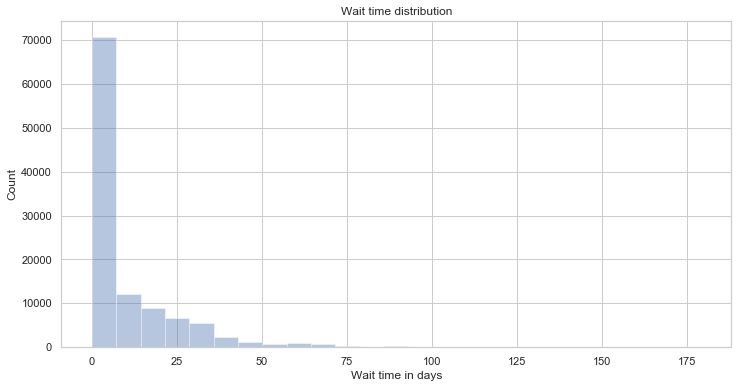

In [17]:
#Histogram of wait_time
plt.figure(figsize=(12,6))
ax = sns.distplot(df.wait_time, bins=25, kde=False)
ax.set_title('Wait time distribution')
ax.set(xlabel='Wait time in days', ylabel='Count');

In [18]:
df.wait_time.value_counts()

0      38561
2       6725
4       5290
1       5213
7       4906
6       4037
5       3277
14      2913
3       2735
8       2332
21      1861
28      1706
13      1682
9       1605
15      1502
10      1391
20      1187
22      1173
16      1151
12      1115
17      1107
29      1089
19      1044
18      1021
27      1013
11       987
35       963
23       822
34       808
26       731
       ...  
103        5
109        5
111        5
98         5
95         5
112        5
108        5
96         4
102        4
105        4
119        4
92         3
122        3
107        2
115        2
93         2
94         2
97         2
110        2
126        1
125        1
123        1
117        1
139        1
82         1
101        1
132        1
151        1
146        1
127        1
Name: wait_time, Length: 129, dtype: int64

As we can see, the data is skewed to the right, with most appoinments (38,561) being made for the same day. 

### Research Question 1

This question examines if there's any statistical relation between the gender of the patient and the likelihood of not showing up for the medical appointment.

In [19]:
# Calculate the rate of no shows per gender
df.groupby('gender').no_show.mean()

gender
F    0.203088
M    0.199638
Name: no_show, dtype: float64

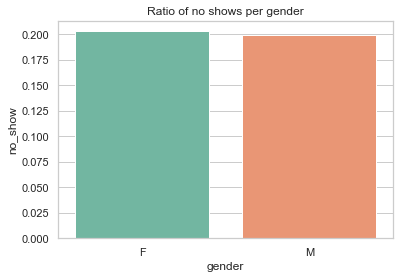

In [20]:
#Visualizing this in a bar chart
gender_ratio = df.groupby('gender').no_show.mean()

sns.set(style='whitegrid')
ax = sns.barplot(x=gender_ratio.index, y=gender_ratio, palette='Set2')
ax.set_title('Ratio of no shows per gender');

There's only a small difference between the percentage of missed appointments: female patients missed about 20.3% of their appointments and male patients missed about 20.0%. Based on this, we might be inclined to conclude that gender has no effect on whether someone shows up or doesn't show up for their appointment. However, at this stage we can't say anything about the statistical significance of this difference.

For comparison, the total number of shows versus no shows:

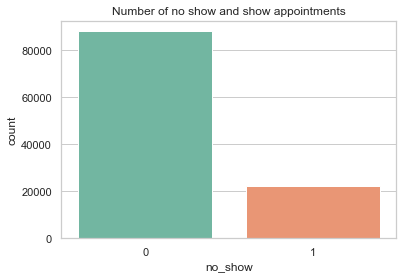

In [21]:
sns.set(style='whitegrid')
ax = sns.countplot(x=df.no_show, data=df, palette='Set2')
ax.set_title('Number of no show and show appointments');

In [22]:
#Mean of no show appointments
df.no_show.mean()

0.20188027073003004

On average, regardless of gender, patients don't show up for about 20% of appointments.

### Research Question 2

This questions is about the potential effect of the waiting time on showing up/missing appointments. 

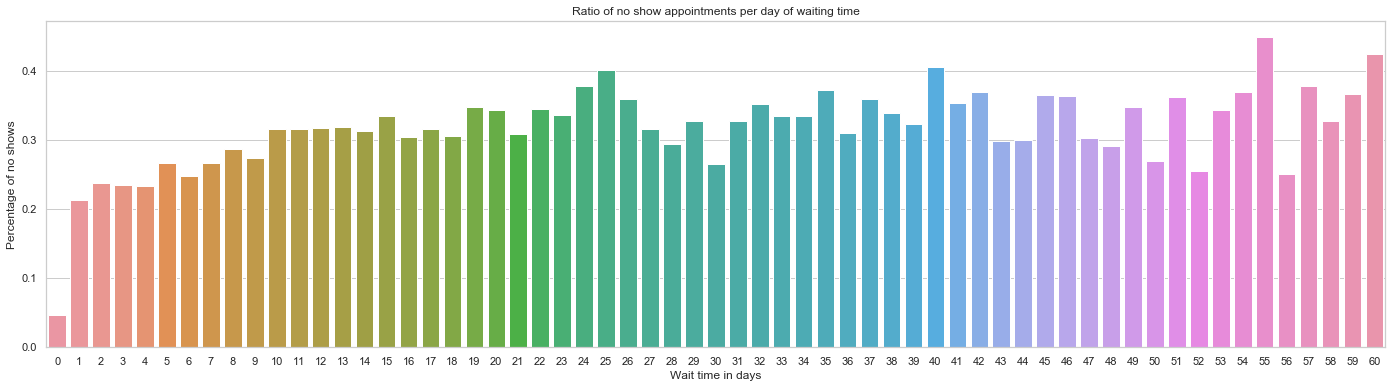

In [23]:
#Calculating the rate of no shows over total appointments per day of wait time
wait_ratio = df.groupby('wait_time').no_show.mean()

#Increasing the figure size from the default
plt.figure(figsize=(24,6))

#This plot cuts off wait times more than 60 days for visibility reasons. The vast majority of appointments have
#wait times less than 60 days.
sns.set(style='whitegrid')
ax = sns.barplot(x=wait_ratio.index, y=wait_ratio, order=df.wait_time.iloc[:61].index)
ax.set_title('Ratio of no show appointments per day of waiting time')
ax.set(xlabel='Wait time in days', ylabel='Percentage of no shows');

As it turns out, a shorter wait time appears to be correlated with less no shows. 

### Research Question 3

Next we'll investigate if there's any apparent relation between age and missed appointments. The chart below shows the rate of missed appointments per age group.

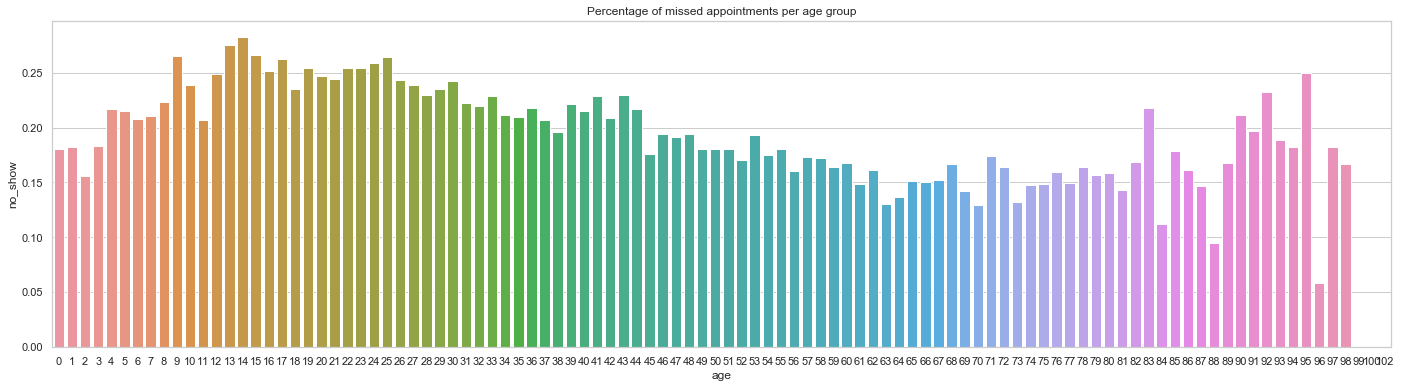

In [24]:
#Calculating the rate of no shows per age group
age_ratio = df.groupby('age').no_show.mean()

#Increasing the size of the plot
plt.figure(figsize=(24,6))

sns.set(style='whitegrid')
ax = sns.barplot(x=age_ratio.index, y=age_ratio)
ax.set_title('Percentage of missed appointments per age group');

From the chart we can see that the share of missed appointments varies per age group, however it doesn't seem to be a simple linear relation. From age 0 to about 14, the share of missed appointments increases. After that it shows a general decline, until the age of 80, after which there are a few peaks. We can calculate the average age of the patients missing the appointments and the average age of those showing up:

In [25]:
#masks to make it easier to see who showed up and who didn't
showed = df.no_show == 0
missed = df.no_show == 1

df.age[showed].mean(), df.age[missed].mean()

(37.7887534720254, 34.3070234413518)

The average age of patients who showed up is 37.8 years, and 34.3 years of those who missed the appointment.

### Research Question 4

So far we've only been looking at descriptive statistics, which doesn't necessarily carry any weigth in terms of statistical significance. This next section makes the step to inferential statistics, and attempts to build a basic regression model with the 3 independent variables we've been examining (gender, wait time, age). Because the dependent variable in this case is categorical, we use a logistic regression to predict wether an appointment will be missed or not.

In [26]:
#Set up dummies for gender variable
df[['male', 'female']] = pd.get_dummies(df['gender'])
#Create an intercept
df['intercept'] = 1
#Run the logistic regression and show the results
logit_mod = sm.Logit(df['no_show'],df[['intercept', 'age', 'wait_time', 'male']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.485404
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                no_show   No. Observations:               110516
Model:                          Logit   Df Residuals:                   110512
Method:                           MLE   Df Model:                            3
Date:                Thu, 06 Sep 2018   Pseudo R-squ.:                 0.03498
Time:                        20:19:10   Log-Likelihood:                -53645.
converged:                       True   LL-Null:                       -55589.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.4290      0.017    -82.365      0.000      -1.463      -1.395
age           -0.0078      0.000    -23.148      0.000      -0.008      -0.007
wait_time      0.0265      0.000     58.737      0.000       0.026       0.027
male           0.0377      0.016      2.333      0.020       0.006       0.069
==============================================================================
"""

In [27]:
#Exponentiate the coefficients so we can interpret them
np.exp(-0.0077), np.exp(0.0265), np.exp(0.0377)

(0.9923295690574124, 1.0268542472616822, 1.0384196602468658)

After exponentiating the coefficients, we can now interprate the results of the regression: 

- For each year increase in age, a patient is 0.99 times as likely to miss an appointment, holding all other variables constant. 

- For each 1 day increase in wait time, a patient is 1.03 times as likely to miss the appointment, holding all other variables constant. 

- A male patient is 1.04 times as likely to miss an appointment than a female patient, holding all other variables constant.

Although the gender dummy has the largest effect, it's P-value isn't as convincing.


## Conclusion

Summarizing what we've learned from our research questions, we find that there's little evidence to support a correlation between gender and the chance of showing up/missing an appointment. The wait time seems positively correlated with no shows: more appointments are missed as the wait time increases. Finally, age apears to be negatively correlated with no shows. Patients of higher age are less likely to miss their medical appointments. 

### Limitations

Other than the logistic regression in research question 4, this project doesn't include any statistical tests. Since it's outside the scope of this project to determine the fit of the model, the statistical significance of the results is uncertain. This also means that we can't say if the sample correctly represents the population. 

Furthermore, the data set only includes about a month's worth of appointments. Adding more data points spread across the course of a year might give a better basis for our analysis. 